# Star-Galaxy separation and Milky Way halo mapping with BHB stars

<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">

<br>
For the Rubin Science Platform at data.lsst.cloud. <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container Size: Medium <br>
Data Release: DP0.2 <br>
Last verified to run: 2025-05-01 <br>

**Learning objective:** Understand the star-galaxy separation in DP0.2 and compute the Milky Way halo density profile using blue horizontal branch (BHB) stars.

**LSST Data Products:** `Object` table, `deepCoadd` image

**Packages:** `lsst.rsp`, `lsst.daf`, `lsst.afw`


**Credit:**
Based on DP0.2 tutorial notebooks originally developed by the Rubin Community Science team (03_Image_Display_and_Manipulation.ipynb, DP0.2 notebook 08_Truth_Tables.ipynb), as well as by deligate-contributed content (Milky_Way_halo_density.ipynb, intro_to_star_gal_sep.ipynb). Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there. 

## 1. Introduction

The DP0.2 dataset contains simulated stars in Milky Way [Section 5.3 in The LSST Dark Energy Science Collaboration et al. 2021](https://iopscience.iop.org/article/10.3847/1538-4365/abd62c). The first part of this tutorial examines how star–galaxy separation is computed in DP0.2 and investigates its performance. The second part computes the Milky Way halo density profile using BHB stars. Use these two short examples to learn how to access and work with DP0.2 data products, and to get a sense of how to condust stellar and Milky Way science with the LSST.

### 1.1. Package imports

Import general python packages, and specific packages from the [LSST Science Pipelines](https://pipelines.lsst.io/).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

### 1.2. Define parameters

Set the default display backend for `afwDisplay` to `matplotlib` using the `setDefaultBackend()` function.

In [ ]:
afwDisplay.setDefaultBackend('matplotlib')

Set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other parameters to make the default plot style be color-blind friendly and otherwise make plots look nice.

In [ ]:
params = {'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 10,
          'xtick.minor.size': 5,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 10,
          'ytick.minor.size': 5,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

In [ ]:
plt.style.use('tableau-colorblind10')

## 2. Star-Galaxy separation

Ensure robust star/galaxy classification, especially at faint magnitudes where rising galaxy counts and shrinking angular sizes degrade separation performance. Misclassified galaxies can contaminate stellar samples, compromising science cases—particularly for detecting rare halo structures.

The <a href="https://sdm-schemas.lsst.io/dp02.html#Object.refExtendedness">DP0.2 Object table schema</a> specifies that the `refExtendedness` parameter is _\"Set to 1 for extended sources, 0 for point sources. Reference band.\"_, and that there are also per-band extendedness parameters.

The `refExtendedness` parameter in DP0.2 is binary, and is based on a simple cut of the ratio of the PSF flux to the model flux in the reference band. DP0.2 Objects should have an `refExtendedness` parameter equal to zero (one) when the ratio of the psfFlux over the cModelFlux is greater (less) than 0.985.

### 2.1. Investigate star-galaxy separation performance with random objects 

#### 2.1.1. Query random 50000 objects

Instantiate the TAP service.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Write a query to retreive $u,g,r$ magnitudes and `repExtendedness` for 50000 random objects.

In [ ]:
query = """
        SELECT TOP 50000
        scisql_nanojanskyToAbMag(u_psfFlux) AS umag, 
        scisql_nanojanskyToAbMag(g_psfFlux) AS gmag, 
        scisql_nanojanskyToAbMag(r_psfFlux) AS rmag,
        refExtendedness
        FROM dp02_dc2_catalogs.Object
        Where detect_isPrimary = 1
        AND u_psfFlux > 360
        """

Run the query as an asynchronous job.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Fetch the results and convert them to an Astropy table, then take a look at the table.

In [ ]:
results = job.fetch_result().to_table()
results

#### 2.1.2 Extendedness of the retreived objects

In [ ]:
plt.figure(figsize=(4,4))
h = plt.hist(results['refExtendedness'])
plt.xlabel('refExtendedness')
plt.ylabel('N')
plt.xticks([0, 1], ['0 (Point-like)', '1 (Extended)'])
plt.show()

#### 2.1.3. Plot ($g-r$,$g$) color-magnitude diagram and $g-r$ vs. $u-g$ color-color diagram

In [ ]:
stars = results['refExtendedness'] < 0.5

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(121)
h = plt.hist2d(results['gmag']-results['rmag'], results['gmag'], 
               bins=200, range=((-1,2),(14,27)), norm=LogNorm())
plt.scatter(results['gmag'][stars]-results['rmag'][stars], results['gmag'][stars], c='r', s=2, alpha=0.2)
plt.xlabel('g - r')
plt.ylabel('g')
plt.xlim(h[1].min(),h[1].max())
plt.ylim(h[2].max(),h[2].min())

plt.subplot(122)
h = plt.hist2d(results['umag']-results['gmag'], results['gmag']-results['rmag'], 
               bins=200, range=((-1,3),(-1,2)), norm=LogNorm())
plt.scatter(results['umag'][stars]-results['gmag'][stars], results['gmag'][stars]-results['rmag'][stars], c='r', s=2, alpha=0.2)
plt.xlim(h[1].min(),h[1].max())
plt.ylim(h[2].min(),h[2].max())
plt.xlabel('u - g')
plt.ylabel('g - r')

plt.tight_layout()

### 2.2. Investigate star-galaxy separation performance in a galaxy-cluster region

As the DP0.2 data set is based on simulated data, there is also truth information about whether the Object is a star or a galaxy, which can be compared with the measured properties in the Object table. Using the truth information, this sub-section investigates star–galaxy separation performance from a different angle, demonstrating other data products and functionalities. A random sky region containing a galaxy cluster is selected for this exercise.

#### 2.2.1. Load the image to visualize

First, load the relevant data to display an image of the target sky region. The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines. To access these data, instantiate a Butler directing it to the `dp02` data repository configuration and the `2.2i/runs/DP0.2` collection.  For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and subsequent tutorials in this series.

In [ ]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

With a `Butler` instance initialized, retrieve desired coadded images, stacks of multiple exposures, by specifying the desired tract, patch, and band. To do this, define a dictionary containing the relevant parameters. In this example, we access an *i*-band `deepCoadd` image from a specific tract (`4431`) and patch (`17`), which covers a galaxy cluster.

In [ ]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

Display the `deepCoadd`.

In [ ]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()

#### 2.2.2. Retrieve catalog sources

This section demonstrates how to use TAP to retrieve the catalog data within a polygon defined by the corners of the coadd image.

The following cell extracts the XY values of the corners of the deepCoadd image and converts them to RA, Dec, which are then used as spatial constraints in the query below.

In [ ]:
wcs = coadd.getWcs()

x0 = float(coadd.getX0())
y0 = float(coadd.getY0())
width = coadd.getWidth()
height = coadd.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


Create a query statement for point-like objects within the bounding box corners and join them with the `TruthSummary` table to examine star-galaxy separation performance.

In [ ]:
# build a comma-separated list of your corner coords
corner_str = ", ".join(
    f"{ra},{dec}"
    for ra, dec in zip(ra_corners, dec_corners)
)

query = f"""
SELECT
    mt.id_truth_type,
    mt.match_objectId,
    ts.truth_type,
    obj.objectId,
    obj.coord_ra,
    obj.coord_dec,
    scisql_nanojanskyToAbMag(obj.g_psfFlux) AS gmag, 
    scisql_nanojanskyToAbMag(obj.i_psfFlux) AS imag, 
    obj.refExtendedness
FROM dp02_dc2_catalogs.MatchesTruth AS mt
JOIN dp02_dc2_catalogs.TruthSummary AS ts
    ON mt.id_truth_type = ts.id_truth_type
JOIN dp02_dc2_catalogs.Object AS obj
    ON mt.match_objectId = obj.objectId
WHERE CONTAINS(
    POINT('ICRS', obj.coord_ra, obj.coord_dec),
    POLYGON('ICRS', {corner_str})) = 1
    AND obj.detect_isPrimary = 1
    AND obj.i_psfFluxErr > 0 
    AND obj.i_psfFlux/obj.i_psfFluxErr > 5
    AND obj.refExtendedness < 0.5
"""

Run the query as an asynchronous job.

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Fetch the results and convert them to an Astropy table, then take a look at the table.

In [ ]:
results = job.fetch_result().to_table()
results

Display the image, and overplot the point-like objects on the image. The `truth_type` sets to 1 for galaxies and 2 for stars.

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection=WCS(wcs.getFitsMetadata()))
coadd_extent = (coadd.getBBox().beginX, coadd.getBBox().endX,
                coadd.getBBox().beginY, coadd.getBBox().endY)
ax.imshow(coadd.image.array, cmap='gray_r', vmin=-0.3, vmax=0.5,
          extent=coadd_extent, origin='lower', aspect='auto')
sc = ax.scatter(results['coord_ra'], results['coord_dec'], c=results['truth_type'], 
                transform=ax.get_transform('world'), cmap=plt.cm.RdBu, s=3)
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Truth type')
cbar.set_ticks([1, 2])
cbar.set_ticklabels(['Galaxy', 'Star'])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.show()

#### 2.2.3. Compare the truth object type and the measured `refExtendedness` value

Compare the `truth_type` from the `TruthSummary` table and the `refExtendedness` from the `Object` table using both a histrogram and on a color-magnitude diagram. 

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(121)
h = plt.hist(results['truth_type'], label='Truth_type (1:galaxies, 2: stars)')
h = plt.hist(results['refExtendedness'], label='Object.repExtendness (0:point, 1:extended)')
plt.legend(fontsize=12)
plt.ylim(0, 1.3*h[0].max())
plt.xlabel('Object classification')
plt.ylabel('N')

plt.subplot(122)
galaxies = results['truth_type'] == 1
stars = results['truth_type'] == 2
plt.scatter(results['gmag'][stars]-results['imag'][stars], 
            results['gmag'][stars], s=5, c='b', alpha=0.5, label='stars')
plt.scatter(results['gmag'][galaxies]-results['imag'][galaxies], 
            results['gmag'][galaxies], s=5, c='r', alpha=0.5, label='galaxies')
plt.legend()
plt.xlim(-1,5)
plt.ylim(30,15)
plt.xlabel('g-i')
plt.ylabel('g')

plt.tight_layout()

# 3. Milky Way Halo Density

This section explores what the DP0.2 dataset reveals about the structure of the simulated Milky Way using BHB stars as tracers. BHB stars represent old, metal-poor populations like the halo, and serve as reliable distance indicators.

BHB stars have distinctively blue colors that stand out in a CMD at fixed distance, but in wide-area surveys they overlap with contaminants like nearby white dwarfs (WDs), distant quasars (QSOs), and blue stragglers. Since querying all blue point-like sources from the `Object` table across the full DP0.2 sky coverage is time-consuming, skip this step to save time. For the BHB selection process, refer to [Milky_Way_halo_density.ipynb](https://github.com/rubin-dp0/delegate-contributions-dp02/blob/main/MWhalo_density/Milky_Way_halo_density.ipynb). 

Once the BHB sample is identified, estimate their distances and construct the radial density profile of the Milky Way halo. Fit a power-law to this profile and compare it to the known simulated halo from DC2. 

The figure below highlights the final BHB stars selected using three different color–color spaces. 

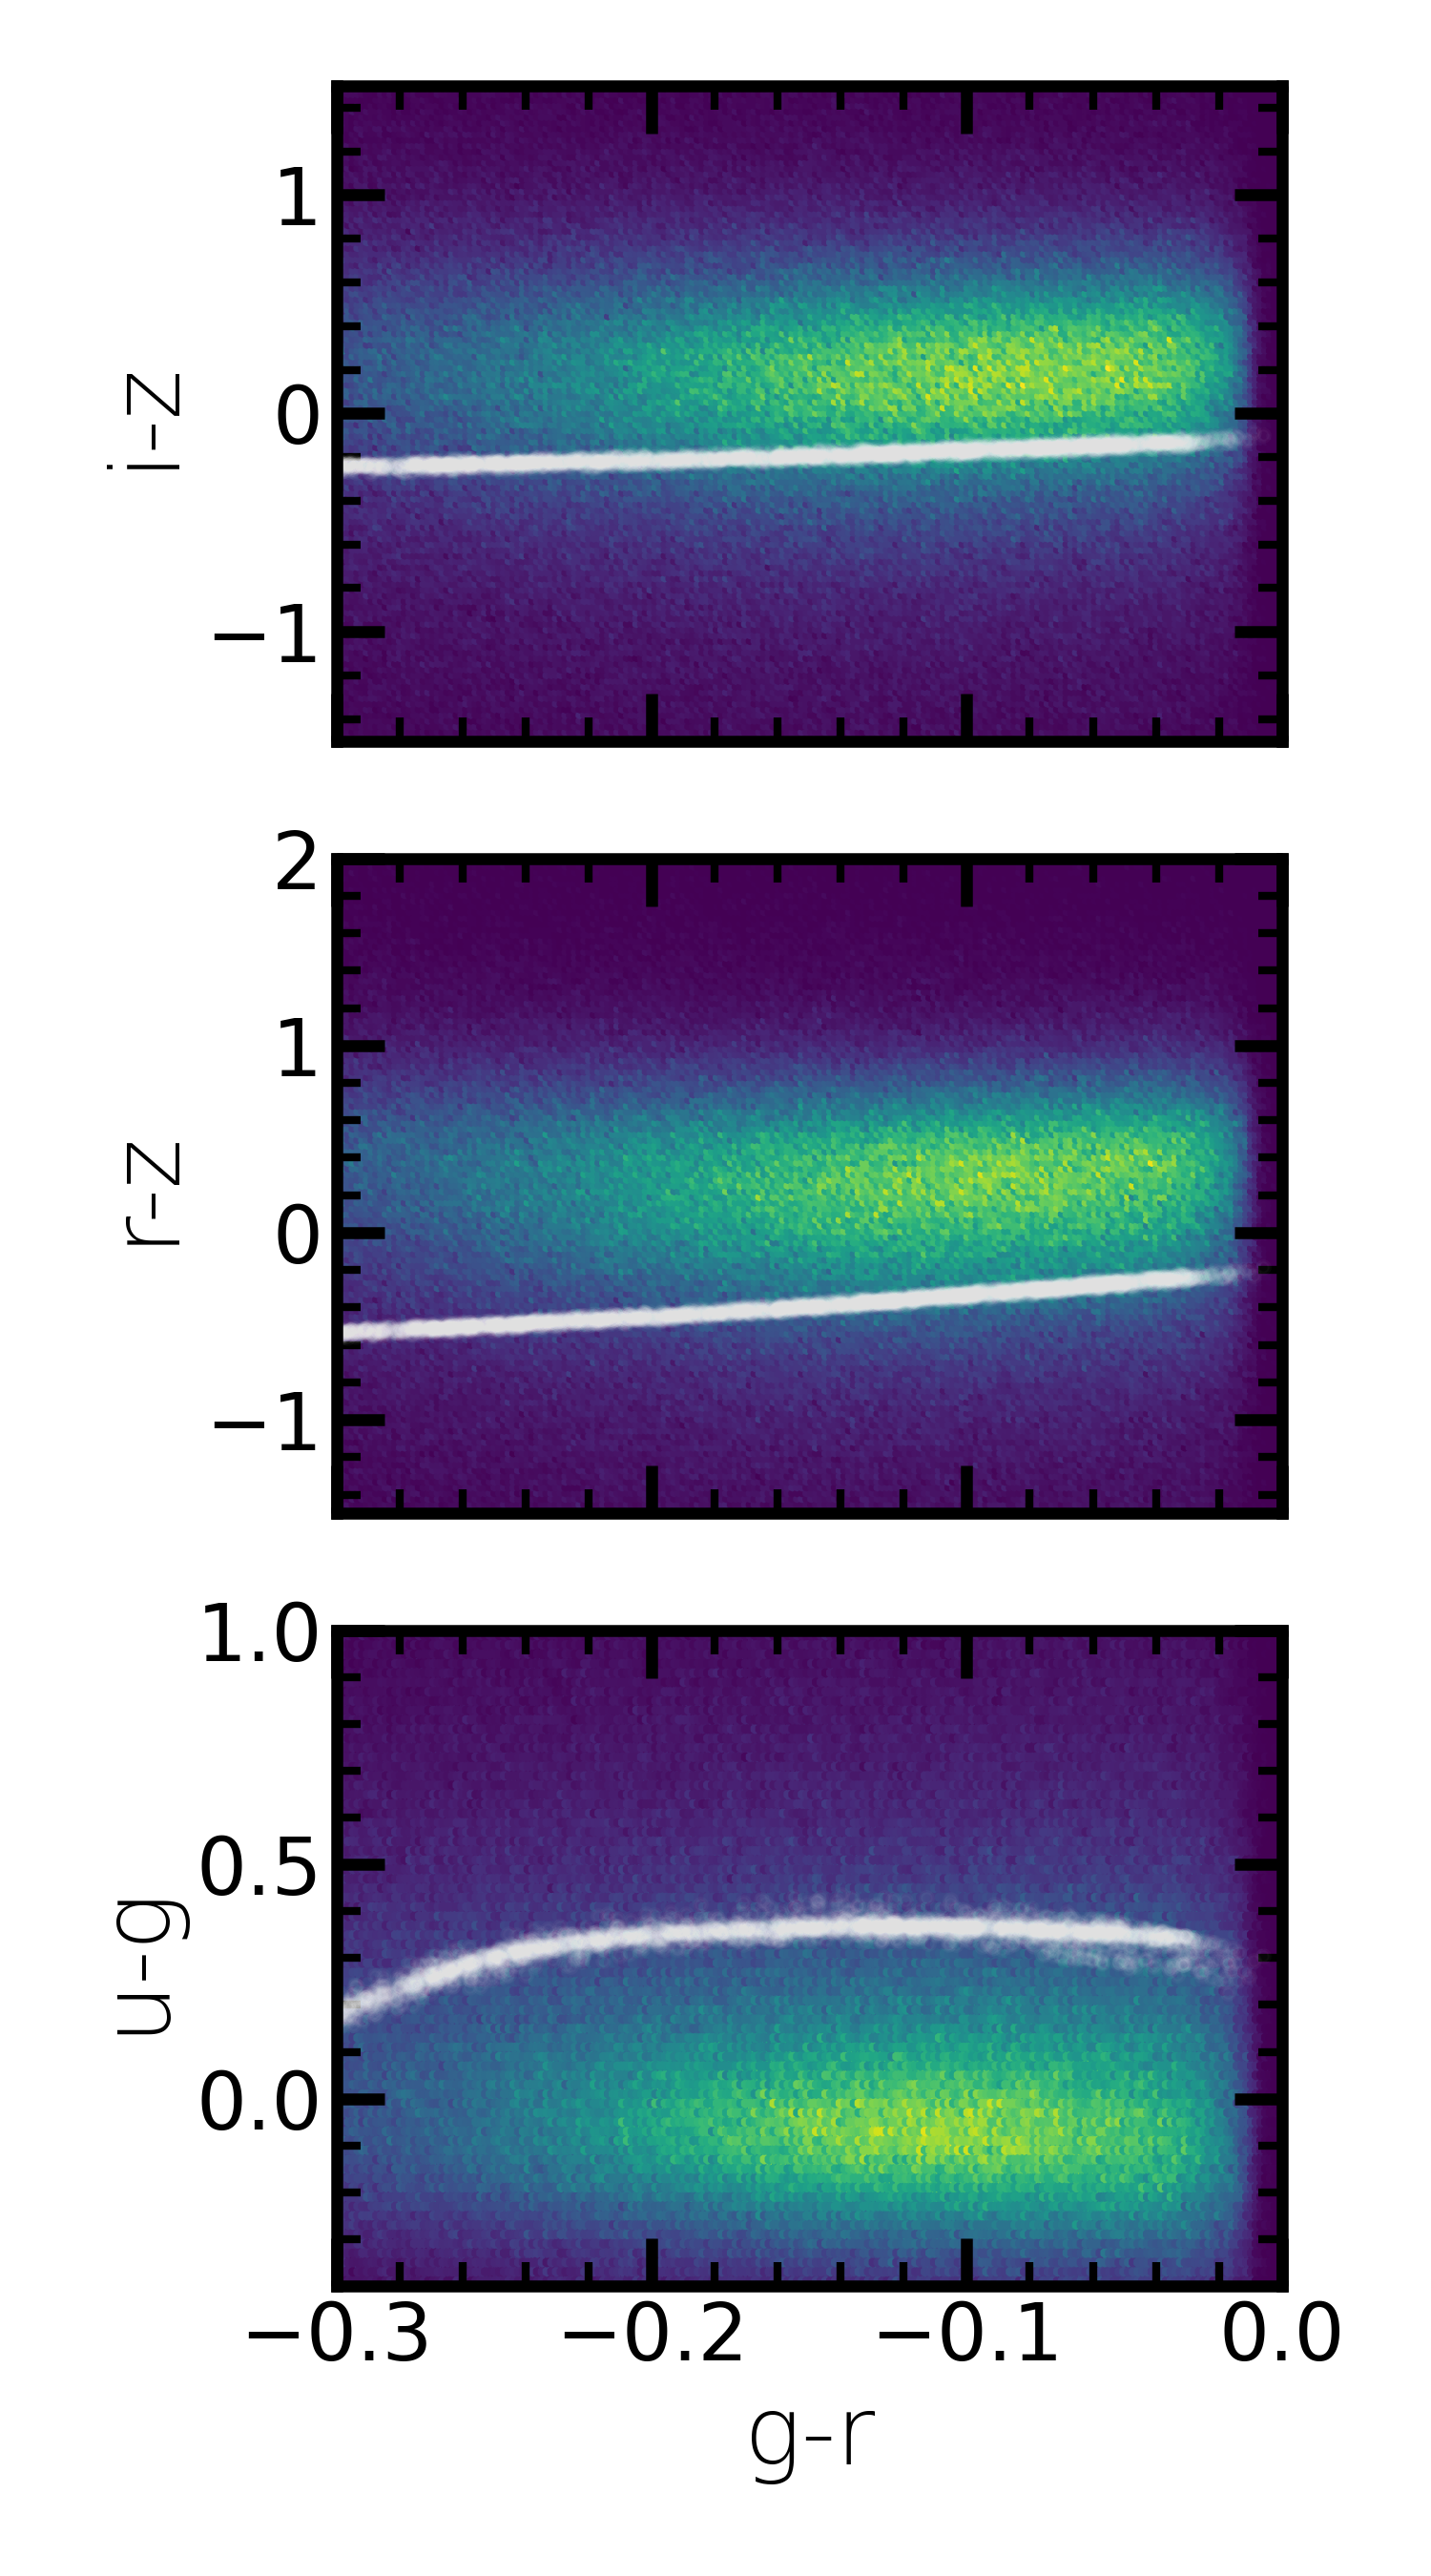

### 3.1. Measure the distance to individual BHB stars

Read in the FITS file containing the selected BHB star sample.

In [ ]:
bhb = Table.read('./bhb_dp02_final.fits')

From [Deason et al. 2011](https://ui.adsabs.harvard.edu/abs/2011MNRAS.416.2903D/abstract), the absolute magnitudes of BHB stars are related to their colors by:

$M_{g, BHB} = 0.434 − 0.169(g − r) + 2.319(g − r)^2 +20.449(g − r)^3 + 94.517(g − r)^4$

_Caveat: this relation is based on SDSS data. One should rederive the relation for DC2 to do this properly. Nonetheless, this likely only contributes a few percent error to the distances._

The following cell applies this relation to go from measured $g$ and $r$-band magnitudes to distances in kpc.

In [ ]:
def bhbMagToDistKpc(gmag, rmag):
    gr = gmag-rmag
    M_g = 0.434 - (0.169*gr) + 2.319*(gr**2) + 20.449*(gr**3) + 94.517*(gr**4)
    distmod = gmag-M_g
    dist_pc = 10.0**((distmod + 5.0)/5.0)
    dist_kpc = dist_pc/1000.0
    return dist_kpc

Compute distances for individual BHB stars.

In [ ]:
bhb_dist_kpc = bhbMagToDistKpc(bhb['gmag0'], bhb['rmag0'])

Create a `SkyCoord` object and define the 3D positions of the selected BHB stars in the ICRS frame.

In [ ]:
sc_bhb = SkyCoord(ra=bhb['coord_ra']*u.deg,
                  dec=bhb['coord_dec']*u.deg,
                  distance=bhb_dist_kpc*u.kpc, frame='icrs')

The distances are as measured from the Sun ("heliocentric"). Since we're interested in the Milky Way's radial density profile, convert the distances to Galactocentric, then calculate the radial distance from the Galactic center.

In [ ]:
rad_bhb = np.sqrt(sc_bhb.galactocentric.x**2
                  + sc_bhb.galactocentric.y**2
                  + sc_bhb.galactocentric.z**2)

### 3.2. Compute a radial density profile of the selected BHB stars

Bin the BHB stars by Galactocentric radius using 10 kpc-wide spherical shells from 0 to 600 kpc. For each bin, count the number of stars and compute the shell volume. Then, calculate the number density by dividing the star counts by the corresponding volumes. Repeat the same steps for a selected subsample to compare density profiles.

In [ ]:
binwidth_kpc = 10.0
radbins = np.arange(0, 600, binwidth_kpc)
nbhb_bins, bhb_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bin_edges = bhb_bin_edges[:-1]
bin_centers = bin_edges+(binwidth_kpc/2)
volume_bins = np.array([(4.0/3.0)*np.pi*(((rad+binwidth_kpc)**3)-(rad**3)) for rad in bin_edges])
bhb_density_bins = nbhb_bins/volume_bins

nbhb_sel_bins, bhb_sel_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bhb_sel_density_bins = nbhb_sel_bins/volume_bins

Plot the radial density profile.

In [ ]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='DodgerBlue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, '.', c='DodgerBlue', ms=10, label='__none__')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

### 3.3 Power-law fit

Fit a power-law to the radial density profile in the form $\rho(R) \propto R^{-n}$, where $R$ is the Galactocentric radius, $\rho(R)$ is the BHB number density, and $n$ is the power-law slope to be determined.

Note that because BHB stars at distances $\lesssim 50$ kpc are bright and often saturated in the DP0.2 dataset, we limit the fit to $70 < R < 300$ kpc. We use the `numpy` function `polyfit`.

In [ ]:
okfit_bins = (bin_centers > 70.0) & (bin_centers < 300.0)
bhb_sel_powerlaw_fit = np.polyfit(bin_centers[okfit_bins],
                                  np.log10(bhb_sel_density_bins[okfit_bins]),
                                  1)
print('Power-law fit: ', bhb_sel_powerlaw_fit)

bhb_sel_powerlaw = np.poly1d(bhb_sel_powerlaw_fit)

Overplot the power-law fit to the measured radial density profile.

In [ ]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='DodgerBlue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, '.', c='DodgerBlue', ms=10, label='__none__')
plt.plot(bin_centers, 10.0**bhb_sel_powerlaw(bin_centers), linestyle='--', color='black',
         label='polynomial fit, n='+f'{abs(bhb_sel_powerlaw_fit[1]):.2f}')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

According to [Jurić et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...673..864J), the best-fit halo density profile from SDSS follows $\rho \propto R^{-2.8}$ (see their Table 5). The `galfast` model used in DC2 adopts Milky Way parameters from that work, so our expected power-law slope is $n_{\mathrm{expected}} = 2.8$. Our fit yields $n = 2.71$, which is remarkably consistent given the simplicity of our approach.

#### Notes:

We don’t necessarily expect the Milky Way to host stars out to 600 kpc, as its virial radius is estimated to be ~300 kpc. However, the simulated dataset includes stars out to 1 Mpc (as defined in the `galfast` code).

In this exercise, we’ve assumed a spherical halo, though the actual halo is likely non-spherical (e.g., Jurić et al. 2008 found an oblate shape with $q \sim 0.6$). With data covering only a narrow region of sky, such asymmetries are hard to constrain.

Finally, it’s worth noting that identifying the BHB sequence was relatively straightforward in this clean simulated dataset, but in real LSST data, challenges like contamination from blue stragglers and halo substructure will make the selection far more complex.